#### Grey Wolf Optimization

The first step to define an optimizer is to define the domain on which the solution is searched. 

Second step is to define what we call error from optimum value or the loss function or the fitness function based on which solutions are judged. 

Third step is to generate random solutions from the domain and judge them based on loss function. 

Next, we update these solutions or solution based on an update expression which is expected to minimize the loss function further. 

In the present code, the loss function/error defined will be mostly based on the previous code for TDOA. We'll just have to make the form amenable to the algorithm we want to run. 

For the present solution we would generate some synthetic time of arrivals beforehand and then using that data we'll process it further. The identified domain is a rectangular domain of size 1km * 1km.


In [1]:
# importing required libraries 

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# defining a suitable fitness function
n_rec = 5 # number of receivers
def fitness_GWO(pos_matrix,ToA,wave_vel):
    '''The function returns the error value for a given position matrix(pos_matrix) consisting of source location as the first element
    and the receiver positions as all the rest elements. ToA is a vector of the time of arrival of seismic waves for receivers
    Wave_vel is the velocity of waves'''
    
    n_rec = np.shape(ToA)[0]
    TDoA = np.zeros(shape= (n_rec-1)) # created a new variable which will store time difference wrt the first receiver
    TDoA[:] = (ToA[1:] - ToA[0]).reshape(n_rec-1)
    # Now getting the value for time of arrival from the position of source and receivers
    ToA_pos = np.zeros_like(ToA)
    pos_diff = np.zeros(shape = (np.shape(pos_matrix)[0],np.shape(pos_matrix)[1]-1))  # vector denoting the position of receivers wrt source
    pos_diff = pos_matrix[1:] - pos_matrix[0]
    ToA_pos[:] = (np.sqrt(pos_diff[:,0]**2 + pos_diff[:,1]**2)).reshape(n_rec,1)/wave_vel
    TDoA_pos = np.zeros_like(TDoA)
    TDoA_pos[:] = (ToA_pos[1:] - ToA_pos[0]).reshape(n_rec-1)
    error_vector = TDoA_pos - TDoA
    error = np.dot(error_vector.T,error_vector)
    
    return error

In [3]:
# Now generating the synthetic data for testing
wave_vel = 1 # m/s

rec_pos_actual =300 + np.random.normal(loc=0.0,scale =100,size = (n_rec,2))  # actual position for 2 receivers
src_pos_actual = np.array([0,0])
t_rec_ideal = np.zeros(shape =(n_rec,1))
# calculating the ideal time of arrival
t_rec_ideal[0:n_rec] = np.sqrt((rec_pos_actual[0:n_rec,1]-src_pos_actual[1])**2 + (rec_pos_actual[0:n_rec,0]-src_pos_actual[0])**2).reshape(n_rec,1)
#introducing noise to account for error in onset detection and sensor
noise_t = np.random.normal(loc=0.0,scale =0.2,size = (n_rec,1))
t_Rec_real = np.array(t_rec_ideal + noise_t)

In [4]:
# Now generating some random solutions for input and intializing number of wolves and their types, alpha, beta and delta are taken to be one each 

n_wolves = 8 # number of wolves 
initial_pos = 300  + np.random.normal(loc=0.0,scale =100,size = (n_wolves,n_rec+1,2))  # in order to make sure that the spread is in entire domain


In [5]:
# giving some initial values to alpha, beta and gamma wolves

alpha_pos =300 + np.random.normal(loc=0.0,scale =100,size = (n_rec+1,2))
alpha_fitness = fitness_GWO(alpha_pos,t_Rec_real,wave_vel = wave_vel)
beta_pos = 300  + np.random.normal(loc=0.0,scale =100,size = (n_rec+1,2))
beta_fitness = fitness_GWO(alpha_pos,t_Rec_real,wave_vel = wave_vel)
delta_pos = 300  + np.random.normal(loc=0.0,scale =100,size = (n_rec+1,2))
delta_fitness = fitness_GWO(alpha_pos,t_Rec_real,wave_vel = wave_vel)

In [6]:
n_iter = 100 # number of iterations
wolves_pos = np.copy(initial_pos)# creating a single vector for positions as update expression will be similar
'''fitness_value = np.zeros(shape= n_wolves)

# First intialising the alpha, beta and delta
for j in range(n_wolves):
    fitness_value[j] = fitness_GWO(wolves_pos[j],t_Rec_real,wave_vel = wave_vel)
    
alpha_pos[:,:] = initial_pos[np.where(fitness_value == np.min(fitness_value)),:,:]
alpha_fitness = fitness_value[np.where(fitness_value == np.min(fitness_value))]
fitness_value[np.where(fitness_value == np.min(fitness_value))] = fitness_value[np.where(fitness_value == np.min(fitness_value))]*3000 # won't be minimum now hopefully

beta_pos[:,:] = initial_pos[np.where(fitness_value == np.min(fitness_value)),:,:]
beta_fitness = fitness_value[np.where(fitness_value == np.min(fitness_value))]
fitness_value[np.where(fitness_value == np.min(fitness_value))] = fitness_value[np.where(fitness_value == np.min(fitness_value))]*3000# won't be minimum now hopefully

delta_pos[:,:] = initial_pos[np.where(fitness_value == np.min(fitness_value)),:,:]
delta_fitness = fitness_value[np.where(fitness_value == np.min(fitness_value))]
fitness_value[np.where(fitness_value == np.min(fitness_value))] = fitness_value[np.where(fitness_value == np.min(fitness_value))]*3000 # won't be minimum now hopefully'''

"fitness_value = np.zeros(shape= n_wolves)\n\n# First intialising the alpha, beta and delta\nfor j in range(n_wolves):\n    fitness_value[j] = fitness_GWO(wolves_pos[j],t_Rec_real,wave_vel = wave_vel)\n    \nalpha_pos[:,:] = initial_pos[np.where(fitness_value == np.min(fitness_value)),:,:]\nalpha_fitness = fitness_value[np.where(fitness_value == np.min(fitness_value))]\nfitness_value[np.where(fitness_value == np.min(fitness_value))] = fitness_value[np.where(fitness_value == np.min(fitness_value))]*3000 # won't be minimum now hopefully\n\nbeta_pos[:,:] = initial_pos[np.where(fitness_value == np.min(fitness_value)),:,:]\nbeta_fitness = fitness_value[np.where(fitness_value == np.min(fitness_value))]\nfitness_value[np.where(fitness_value == np.min(fitness_value))] = fitness_value[np.where(fitness_value == np.min(fitness_value))]*3000# won't be minimum now hopefully\n\ndelta_pos[:,:] = initial_pos[np.where(fitness_value == np.min(fitness_value)),:,:]\ndelta_fitness = fitness_value[np.where(

In [7]:
# After this initial assigning of hierarchy, let's create the update expression
# Note: The first assigned hierarchy is just to ensure that the variables are not blank. This might be removed in revision

a = 2  
fitness_value = np.zeros(shape= n_wolves)

for i in range(n_iter):
    for j in range(n_wolves):
        fitness_value[j] = fitness_GWO(wolves_pos[j],t_Rec_real,wave_vel = wave_vel)
        if fitness_value[j] <= alpha_fitness:
            delta_fitness = beta_fitness
            delta_pos = np.copy(beta_pos)
            beta_fitness = alpha_fitness
            beta_pos = np.copy(alpha_pos)
            alpha_fitness = fitness_value[j]
            alpha_pos = np.copy(wolves_pos[j])
            
        elif fitness_value[j] <= beta_fitness and fitness_value[j] >= alpha_fitness:
            delta_fitness = beta_fitness
            delta_pos = np.copy(beta_pos)
            beta_fitness = fitness_value[j]
            beta_pos = np.copy(wolves_pos[j])
            
        elif fitness_value[j] <= delta_fitness and fitness_value[j] >= beta_fitness:
            delta_fitness = fitness_value[j]
            delta_pos = np.copy(wolves_pos[j])
    
    #Now that hierarchy is assigned let's update the positions
    
    a= a - 2/n_iter
    
    for j in range(n_wolves):
        r1 = np.random.random(size=(np.shape(alpha_pos)))
        r2 = np.random.random(size=(np.shape(alpha_pos)))
        A1 = 2*a*r1 - a
        C1 =2*r2
    
        D_alpha = abs(C1 * alpha_pos - wolves_pos[j])  # distance from the alpha wolf
        X1 = alpha_pos - A1 * D_alpha

        r1 = np.random.random(size=(np.shape(alpha_pos)))
        r2 = np.random.random(size=(np.shape(alpha_pos)))
        A2 = 2*a*r1 - a
        C2 =2*r2
    
        D_beta =abs(C2 * beta_pos - wolves_pos[j])
        # Equation (3.5)-part 2
        X2 = beta_pos - A2 * D_beta
    
        r1 = np.random.random(size=(np.shape(alpha_pos)))
        r2 = np.random.random(size=(np.shape(alpha_pos)))
        A3 = 2*a*r1 - a
        C3 =2*r2
        D_delta = abs(C3 * delta_pos- wolves_pos[j])
        X3 = delta_pos - A3*D_delta
        
        wolves_pos[j] = (X1+X2+X3)/3
    
    
    
            
        

(-500.0, 500.0)

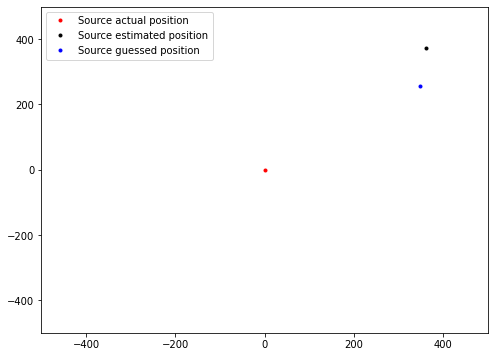

In [8]:
# Examining the results via plot
plt.figure(figsize=(8,6))
#plt.plot(rec_pos_actual[:,0],rec_pos_actual[:,1],'b.',label='Receivers actual position')
plt.plot(src_pos_actual[0],src_pos_actual[1],'r.',label='Source actual position')
#plt.plot(alpha_pos[1:,0],alpha_pos[1:,1],'g.',label='Receivers estimated position')
plt.plot(alpha_pos[0,0],alpha_pos[0,1],'k.',label='Source estimated position')
plt.plot(initial_pos[0,0,0],initial_pos[0,0,1],'b.',label='Source guessed position')

plt.legend()
plt.xlim(-500,500)
plt.ylim(-500,500)

(-500.0, 500.0)

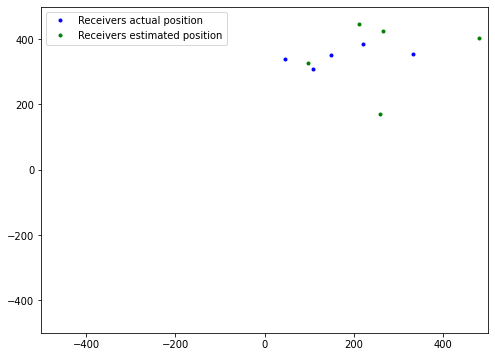

In [9]:
plt.figure(figsize=(8,6))
plt.plot(rec_pos_actual[:,0],rec_pos_actual[:,1],'b.',label='Receivers actual position')
#plt.plot(initial_pos[0,1:,0],initial_pos[0,1:,1],'k.',label='REceivers guessed position')
plt.plot(alpha_pos[1:,0],alpha_pos[1:,1],'g.',label='Receivers estimated position')


plt.legend()
plt.xlim(-500,500)
plt.ylim(-500,500)